In [53]:
import numpy as np
import pandas as pd
sp500 = pd.read_csv('../CQF_Jan_24_M1L1_Excel-1.csv', usecols=[0,4])

In [54]:
sp500

,Date,Close
0,30/12/1927,17.660000
1,03/01/1928,17.760000
2,04/01/1928,17.719999
3,05/01/1928,17.549999
4,06/01/1928,17.660000
...,...,...
24123,12/01/2024,4783.830078
24124,16/01/2024,4765.979980
24125,17/01/2024,4739.209961
24126,18/01/2024,4780.939941


## 1

We consider the 1D, 2D & 5D returns with $R_i = \frac{S_{t+n} - S_t}{S_t}$:

In [55]:
def get_rtns(col, n):
    return (col - col.shift(n)) / col.shift(n)

sp500['1D_rtns'] = get_rtns(sp500['Close'], 1)
sp500['2D_rtns'] = get_rtns(sp500['Close'], 2)
sp500['5D_rtns'] = get_rtns(sp500['Close'], 5)

display(sp500)

,Date,Close,1D_rtns,2D_rtns,5D_rtns
0,30/12/1927,17.660000,NaN,NaN,NaN
1,03/01/1928,17.760000,0.005663,NaN,NaN
2,04/01/1928,17.719999,-0.002252,0.003397,NaN
3,05/01/1928,17.549999,-0.009594,-0.011824,NaN
4,06/01/1928,17.660000,0.006268,-0.003386,NaN
...,...,...,...,...,...
24123,12/01/2024,4783.830078,0.000751,0.000079,0.018434
24124,16/01/2024,4765.979980,-0.003731,-0.002983,0.000512
24125,17/01/2024,4739.209961,-0.005617,-0.009327,-0.003635
24126,18/01/2024,4780.939941,0.008805,0.003139,-0.000525


We then calculate $\sigma_{nD}$ for $n=1,2,5$ and check the difference with $\sigma_{1D}$. They appear to be comparable, within 3% error

In [56]:
std1 = np.std(sp500[f'{1}D_rtns'])
for i in [1,2,5]:
    std = np.std(sp500[f'{i}D_rtns'])
    print(f'Unadjusted sigma_{i}D = {std}')
    print(f'Adjusted sigma_{i}D   = {std / np.sqrt(i)}')
    print(f'Adjusted sigma_{i}D % error with sigma_1D = {(std / np.sqrt(i) - std1) / std1 * 100}%')
    print()

Unadjusted sigma_1D = 0.011964325009182734
Adjusted sigma_1D   = 0.011964325009182734
Adjusted sigma_1D % error with sigma_1D = 0.0%

Unadjusted sigma_2D = 0.01679579090302241
Adjusted sigma_2D   = 0.011876417642918474
Adjusted sigma_2D % error with sigma_1D = -0.734745722778263%

Unadjusted sigma_5D = 0.026143283244085828
Adjusted sigma_5D   = 0.011691631697761428
Adjusted sigma_5D % error with sigma_1D = -2.279220191795288%



## 2
We split into even/odd observations and compute $\mu_{1D}, \sigma_{1D}$:

In [57]:
evens = sp500['Close'][::2]
odds = sp500['Close'][1::2]

mean_evens = evens.mean()
std_evens = evens.std()
mean_odds = odds.mean()
std_odds = odds.std()

print(f'Evens: mu = {mean_evens}, sigma = {std_evens}')
print(f'Odds: mu = {mean_odds}, sigma = {mean_odds }')

Evens: mu = 610.6832525522215, sigma = 978.4220226011486
Odds: mu = 610.8797530760112, sigma = 610.8797530760112


It appears that they have similar means, but the standard deviations differ by a lot (50%ish)

## 3
We get a fresh copy of the database, to construct the QQ plot:

In [58]:
sp500_2 = pd.read_csv('../CQF_Jan_24_M1L1_Excel-1.csv', usecols=[0,4])

1. We calculate the historic log returns and scale them

In [59]:
from scipy.stats import norm

sp500_2['historic'] = np.log(sp500_2['Close']/sp500_2['Close'].shift(1))
sp500_2['scaled'] = (sp500_2['historic'] - sp500_2['historic'].mean()) / sp500_2['historic'].std()

2. We sort and introduce an index column, $i$.

In [60]:
returns_df = sp500_2['scaled'].dropna().sort_values().to_frame()
returns_df = returns_df.reset_index(drop=True)
returns_df['i'] = returns_df.index+1
returns_df

,scaled,i
0,-19.125458,1
1,-11.581281,2
2,-10.669882,3
3,-8.956899,4
4,-8.779553,5
...,...,...
24122,9.295103,24123
24123,9.330453,24124
24124,9.702468,24125
24125,9.830325,24126


3. We introduce the cumulative density, i.e $i/N$

In [61]:
returns_df['i/N'] = returns_df['i']/len(returns_df['i'])
returns_df

,scaled,i,i/N
0,-19.125458,1,0.000041
1,-11.581281,2,0.000083
2,-10.669882,3,0.000124
3,-8.956899,4,0.000166
4,-8.779553,5,0.000207
...,...,...,...
24122,9.295103,24123,0.999834
24123,9.330453,24124,0.999876
24124,9.702468,24125,0.999917
24125,9.830325,24126,0.999959


4. Then we use the normal inverse function to get the probability mass of $1/N$

In [62]:
from scipy.stats import norm

returns_df['Standard'] = norm.ppf(returns_df['i/N'])
returns_df

,scaled,i,i/N,Standard
0,-19.125458,1,0.000041,-3.935873
1,-11.581281,2,0.000083,-3.766142
2,-10.669882,3,0.000124,-3.663611
3,-8.956899,4,0.000166,-3.589291
4,-8.779553,5,0.000207,-3.530692
...,...,...,...,...
24122,9.295103,24123,0.999834,3.589291
24123,9.330453,24124,0.999876,3.663611
24124,9.702468,24125,0.999917,3.766142
24125,9.830325,24126,0.999959,3.935873


5. Finally, we plot the scaled returns (`scaled`) to the Normal percentiles (`Standard`):

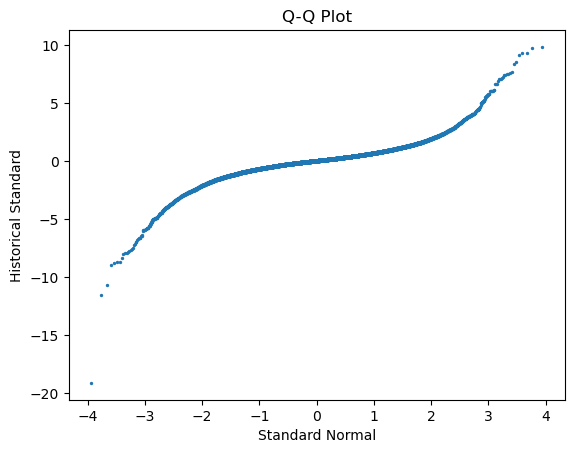

In [65]:
import matplotlib.pyplot as plt

plt.scatter(returns_df['Standard'], returns_df['scaled'], s=2)
plt.title('Q-Q Plot')
plt.xlabel('Standard Normal')
plt.ylabel('Historical Standard')
plt.show()